Dùng NNS tìm gần nhất

In [1]:
import math

# Hàm tính khoảng cách Euclidean giữa 2 điểm (x1, y1) và (x2, y2)
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Tìm n điểm gần nhất với điểm xác định
def find_nearest_points(reference_point, points, n=5):
    # Tính khoảng cách từ điểm xác định tới tất cả các điểm
    distances = [(point, euclidean_distance(reference_point, point)) for point in points]

    # Sắp xếp các điểm theo khoảng cách
    distances.sort(key=lambda x: x[1])

    # Trả về n điểm gần nhất
    return [point for point, dist in distances[:n]]

# Danh sách các tọa độ điểm trên bản đồ
points = [
    (10.7769, 106.7009),  # Tọa độ TP HCM
    (21.0285, 105.8542),  # Tọa độ Hà Nội
    (16.0471, 108.2062),  # Tọa độ Đà Nẵng
    (10.8231, 106.6297),  # Một tọa độ khác tại TP HCM
    (11.9416, 108.4583),  # Tọa độ Đà Lạt
]

# Tọa độ điểm tham chiếu (ví dụ TP HCM)
reference_point = (10.7769, 106.7009)

# Số lượng điểm cần tìm
n = 3

# Tìm n điểm gần nhất
nearest_points = find_nearest_points(reference_point, points, n)

# In kết quả
print(f"Các điểm gần nhất với {reference_point} là:")
for i, point in enumerate(nearest_points, 1):
    print(f"{i}. {point}")

Các điểm gần nhất với (10.7769, 106.7009) là:
1. (10.7769, 106.7009)
2. (10.8231, 106.6297)
3. (11.9416, 108.4583)


Dùng ACO tìm gần nhất

In [2]:
import random
import math

# Hàm tính khoảng cách Euclidean giữa 2 điểm (x1, y1) và (x2, y2)
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Hàm ACO để tìm các điểm gần nhất
class ACO:
    def __init__(self, points, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_ants=10, num_iterations=100):
        self.points = points  # Danh sách các điểm trên bản đồ
        self.num_points = len(points)
        self.alpha = alpha  # Hệ số pheromone
        self.beta = beta  # Hệ số heuristic
        self.evaporation_rate = evaporation_rate  # Tỉ lệ bay hơi pheromone
        self.num_ants = num_ants  # Số lượng kiến
        self.num_iterations = num_iterations  # Số lần lặp lại thuật toán
        self.pheromone = [[1 for _ in range(self.num_points)] for _ in range(self.num_points)]  # Khởi tạo pheromone

    def probability(self, i, j, heuristic):
        # Tính xác suất kiến chọn từ điểm i đến điểm j
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def update_pheromone(self, all_ants_paths, all_ants_lengths):
        # Giảm pheromone cũ (bay hơi)
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.pheromone[i][j] *= (1 - self.evaporation_rate)

        # Cập nhật pheromone dựa trên hành trình của kiến
        for ant in range(self.num_ants):
            for i in range(len(all_ants_paths[ant]) - 1):
                from_point = all_ants_paths[ant][i]
                to_point = all_ants_paths[ant][i + 1]
                self.pheromone[from_point][to_point] += 1.0 / all_ants_lengths[ant]

    def run(self, reference_point, n):
        # Tính ma trận heuristic (khoảng cách nghịch đảo)
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]

        reference_index = self.points.index(reference_point)

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []

            # Mỗi kiến sẽ bắt đầu từ điểm tham chiếu
            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]

                for _ in range(n):
                    probabilities = []
                    total_prob = 0

                    # Tính xác suất di chuyển tới các điểm chưa ghé qua
                    for j in range(self.num_points):
                        if j not in visited:
                            prob = self.probability(current_index, j, heuristic)
                            probabilities.append((j, prob))
                            total_prob += prob

                    # Chọn điểm tiếp theo dựa trên xác suất
                    if total_prob > 0:
                        next_index = random.choices(
                            [point for point, _ in probabilities],
                            [prob / total_prob for _, prob in probabilities]
                        )[0]
                    else:
                        next_index = random.choice([i for i in range(self.num_points) if i not in visited])

                    visited.append(next_index)
                    current_index = next_index

                # Lưu hành trình và độ dài của mỗi kiến
                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)

            # Cập nhật pheromone sau khi tất cả kiến đã di chuyển
            self.update_pheromone(all_ants_paths, all_ants_lengths)

        # Tìm hành trình tốt nhất
        best_path = min(all_ants_paths, key=lambda path: sum([euclidean_distance(self.points[path[i]], self.points[path[i + 1]]) for i in range(len(path) - 1)]))
        return [self.points[i] for i in best_path]

# Tập các tọa độ điểm trên bản đồ (vĩ độ, kinh độ)
points = [
    (10.7769, 106.7009),  # Tọa độ TP HCM
    (21.0285, 105.8542),  # Tọa độ Hà Nội
    (16.0471, 108.2062),  # Tọa độ Đà Nẵng
    (10.8231, 106.6297),  # Một tọa độ khác tại TP HCM
    (11.9416, 108.4583),  # Tọa độ Đà Lạt
]

# Tọa độ điểm tham chiếu
reference_point = (10.7769, 106.7009)  # TP HCM

# Số lượng điểm gần nhất cần tìm
n = 3

# Khởi tạo ACO và chạy thuật toán
aco = ACO(points, num_ants=20, num_iterations=50)
nearest_points = aco.run(reference_point, n)

# In ra kết quả
print(f"Các điểm gần nhất với {reference_point} là:")
for i, point in enumerate(nearest_points, 1):
    print(f"{i}. {point}")


Các điểm gần nhất với (10.7769, 106.7009) là:
1. (10.7769, 106.7009)
2. (10.8231, 106.6297)
3. (11.9416, 108.4583)
4. (16.0471, 108.2062)


Biểu đồ so sánh chi phi giữa 2 thuât toán NNS vs ACO

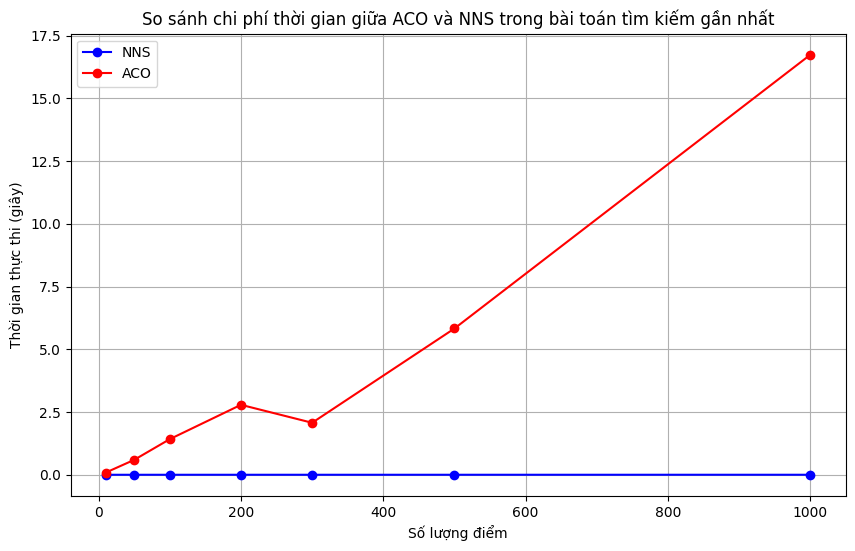

In [3]:
import time
import random
import math
import matplotlib.pyplot as plt

# Hàm tính khoảng cách Euclidean giữa 2 điểm
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Nearest Neighbor Search (NNS)
def nearest_neighbor_search(reference_point, points, n):
    distances = [(point, euclidean_distance(reference_point, point)) for point in points]
    distances.sort(key=lambda x: x[1])
    return [point for point, dist in distances[:n]]

# Ant Colony Optimization (ACO)
class ACO:
    def __init__(self, points, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_ants=10, num_iterations=100):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.pheromone = [[1 for _ in range(self.num_points)] for _ in range(self.num_points)]

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def update_pheromone(self, all_ants_paths, all_ants_lengths):
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.pheromone[i][j] *= (1 - self.evaporation_rate)
        for ant in range(self.num_ants):
            for i in range(len(all_ants_paths[ant]) - 1):
                from_point = all_ants_paths[ant][i]
                to_point = all_ants_paths[ant][i + 1]
                self.pheromone[from_point][to_point] += 1.0 / all_ants_lengths[ant]

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []
            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]
                for _ in range(n):
                    probabilities = []
                    total_prob = 0
                    for j in range(self.num_points):
                        if j not in visited:
                            prob = self.probability(current_index, j, heuristic)
                            probabilities.append((j, prob))
                            total_prob += prob
                    if total_prob > 0:
                        next_index = random.choices(
                            [point for point, _ in probabilities],
                            [prob / total_prob for _, prob in probabilities]
                        )[0]
                    else:
                        next_index = random.choice([i for i in range(self.num_points) if i not in visited])
                    visited.append(next_index)
                    current_index = next_index
                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)
            self.update_pheromone(all_ants_paths, all_ants_lengths)

        best_path = min(all_ants_paths, key=lambda path: sum([euclidean_distance(self.points[path[i]], self.points[path[i + 1]]) for i in range(len(path) - 1)]))
        return [self.points[i] for i in best_path]

# Tạo ngẫu nhiên các tọa độ điểm
def generate_random_points(num_points):
    return [(random.uniform(-90, 90), random.uniform(-180, 180)) for _ in range(num_points)]

# Số lượng điểm và số lượng gần nhất
num_points_list = [10, 50, 100, 200, 300, 500, 1000]  # Số lượng điểm khác nhau
n = 5  # Số lượng điểm gần nhất cần tìm
reference_point_index = 0

nns_times = []
aco_times = []

for num_points in num_points_list:
    points = generate_random_points(num_points)
    reference_point = points[reference_point_index]

    # Đo thời gian cho NNS
    start_time = time.time()
    nearest_points_nns = nearest_neighbor_search(reference_point, points, n)
    nns_time = time.time() - start_time
    nns_times.append(nns_time)

    # Đo thời gian cho ACO
    aco = ACO(points, num_ants=20, num_iterations=50)
    start_time = time.time()
    nearest_points_aco = aco.run(reference_point, n)
    aco_time = time.time() - start_time
    aco_times.append(aco_time)

# Vẽ biểu đồ so sánh thời gian giữa ACO và NNS
plt.figure(figsize=(10, 6))
plt.plot(num_points_list, nns_times, label='NNS', marker='o', color='blue')
plt.plot(num_points_list, aco_times, label='ACO', marker='o', color='red')
plt.xlabel('Số lượng điểm')
plt.ylabel('Thời gian thực thi (giây)')
plt.title('So sánh chi phí thời gian giữa ACO và NNS trong bài toán tìm kiếm gần nhất')
plt.legend()
plt.grid(True)
plt.show()


Áp dụng ACS trong bài toán tìm kiếm gần nhất

In [4]:
import random
import math

# Hàm tính khoảng cách Euclidean giữa 2 điểm
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Ant Colony System (ACS) Class
class ACS:
    def __init__(self, points, alpha=1.0, beta=2.0, rho=0.1, q0=0.9, evaporation_rate=0.5, num_ants=10, num_iterations=100):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha  # Hệ số pheromone
        self.beta = beta  # Hệ số heuristic (khoảng cách)
        self.rho = rho  # Tốc độ bay hơi pheromone
        self.q0 = q0  # Xác suất khai thác (exploitation)
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants  # Số lượng kiến
        self.num_iterations = num_iterations  # Số lần lặp
        self.pheromone = [[1 for _ in range(self.num_points)] for _ in range(self.num_points)]  # Khởi tạo ma trận pheromone

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def local_update_pheromone(self, i, j):
        self.pheromone[i][j] = (1 - self.rho) * self.pheromone[i][j] + self.rho * 1.0

    def global_update_pheromone(self, best_path):
        for i in range(len(best_path) - 1):
            from_point = best_path[i]
            to_point = best_path[i + 1]
            self.pheromone[from_point][to_point] = (1 - self.evaporation_rate) * self.pheromone[from_point][to_point] + self.evaporation_rate * (1.0 / self.best_length)

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)
        self.best_length = float('inf')
        self.best_path = []

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []

            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]

                for _ in range(n):
                    next_index = None
                    if random.random() < self.q0:
                        # Khai thác (Exploitation): chọn điểm có giá trị cao nhất
                        max_prob = -1
                        for j in range(self.num_points):
                            if j not in visited:
                                prob = self.probability(current_index, j, heuristic)
                                if prob > max_prob:
                                    max_prob = prob
                                    next_index = j
                    else:
                        # Khám phá (Exploration): chọn điểm dựa trên xác suất
                        total_prob = 0
                        probabilities = []
                        for j in range(self.num_points):
                            if j not in visited:
                                prob = self.probability(current_index, j, heuristic)
                                total_prob += prob
                                probabilities.append((j, prob))

                        if total_prob > 0:
                            next_index = random.choices(
                                [point for point, _ in probabilities],
                                [prob / total_prob for _, prob in probabilities]
                            )[0]

                    visited.append(next_index)
                    self.local_update_pheromone(current_index, next_index)  # Cập nhật pheromone cục bộ
                    current_index = next_index

                # Tính tổng độ dài hành trình kiến
                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)

                # Cập nhật hành trình tốt nhất
                if total_length < self.best_length:
                    self.best_length = total_length
                    self.best_path = visited

            # Cập nhật pheromone toàn cục
            self.global_update_pheromone(self.best_path)

        # Trả về các điểm gần nhất
        return [self.points[i] for i in self.best_path[:n]]

# Tạo ngẫu nhiên các tọa độ điểm
def generate_random_points(num_points):
    return [(random.uniform(-90, 90), random.uniform(-180, 180)) for _ in range(num_points)]

# Tập dữ liệu điểm
points = generate_random_points(100)  # 100 điểm
reference_point = points[0]  # Điểm tham chiếu
n = 5  # Tìm 5 điểm gần nhất

# Khởi tạo ACS và tìm các điểm gần nhất
acs = ACS(points, num_ants=20, num_iterations=50)
nearest_points = acs.run(reference_point, n)

# In kết quả
print(f"Các điểm gần nhất với {reference_point} là:")
for i, point in enumerate(nearest_points, 1):
    print(f"{i}. {point}")


Các điểm gần nhất với (35.20342851430574, 112.34132627499343) là:
1. (35.20342851430574, 112.34132627499343)
2. (49.830384903627646, 114.3184211330136)
3. (60.93335619137312, 95.78274988416769)
4. (66.71122821078836, 83.25660809056797)
5. (78.30384022145341, 78.9181725228297)


So sánh chi phi giữa ACO vs ACS

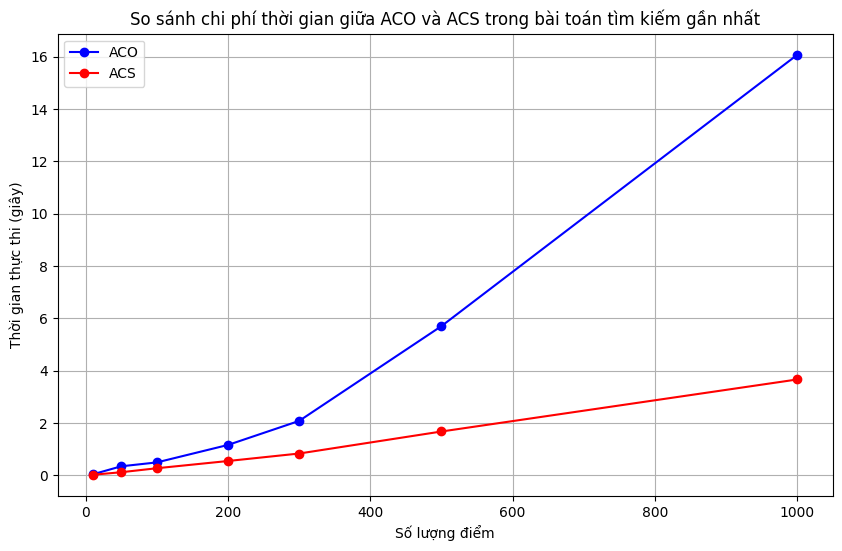

In [5]:
import time
import random
import math
import matplotlib.pyplot as plt

# Hàm tính khoảng cách Euclidean giữa 2 điểm
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Ant Colony Optimization (ACO)
class ACO:
    def __init__(self, points, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_ants=10, num_iterations=100):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.pheromone = [[1 for _ in range(self.num_points)] for _ in range(self.num_points)]

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def update_pheromone(self, all_ants_paths, all_ants_lengths):
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.pheromone[i][j] *= (1 - self.evaporation_rate)
        for ant in range(self.num_ants):
            for i in range(len(all_ants_paths[ant]) - 1):
                from_point = all_ants_paths[ant][i]
                to_point = all_ants_paths[ant][i + 1]
                self.pheromone[from_point][to_point] += 1.0 / all_ants_lengths[ant]

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []
            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]
                for _ in range(n):
                    probabilities = []
                    total_prob = 0
                    for j in range(self.num_points):
                        if j not in visited:
                            prob = self.probability(current_index, j, heuristic)
                            probabilities.append((j, prob))
                            total_prob += prob
                    if total_prob > 0:
                        next_index = random.choices(
                            [point for point, _ in probabilities],
                            [prob / total_prob for _, prob in probabilities]
                        )[0]
                    else:
                        next_index = random.choice([i for i in range(self.num_points) if i not in visited])
                    visited.append(next_index)
                    current_index = next_index
                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)
            self.update_pheromone(all_ants_paths, all_ants_lengths)

        best_path = min(all_ants_paths, key=lambda path: sum([euclidean_distance(self.points[path[i]], self.points[path[i + 1]]) for i in range(len(path) - 1)]))
        return [self.points[i] for i in best_path]

# Ant Colony System (ACS)
class ACS:
    def __init__(self, points, alpha=1.0, beta=2.0, rho=0.1, q0=0.9, evaporation_rate=0.5, num_ants=10, num_iterations=100):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q0 = q0
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.pheromone = [[1 for _ in range(self.num_points)] for _ in range(self.num_points)]

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def local_update_pheromone(self, i, j):
        self.pheromone[i][j] = (1 - self.rho) * self.pheromone[i][j] + self.rho * 1.0

    def global_update_pheromone(self, best_path):
        for i in range(len(best_path) - 1):
            from_point = best_path[i]
            to_point = best_path[i + 1]
            self.pheromone[from_point][to_point] = (1 - self.evaporation_rate) * self.pheromone[from_point][to_point] + self.evaporation_rate * (1.0 / self.best_length)

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)
        self.best_length = float('inf')
        self.best_path = []

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []

            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]

                for _ in range(n):
                    next_index = None
                    if random.random() < self.q0:
                        # Exploitation: chọn điểm có giá trị cao nhất
                        max_prob = -1
                        for j in range(self.num_points):
                            if j not in visited:
                                prob = self.probability(current_index, j, heuristic)
                                if prob > max_prob:
                                    max_prob = prob
                                    next_index = j
                    else:
                        # Exploration: chọn điểm dựa trên xác suất
                        total_prob = 0
                        probabilities = []
                        for j in range(self.num_points):
                            if j not in visited:
                                prob = self.probability(current_index, j, heuristic)
                                total_prob += prob
                                probabilities.append((j, prob))

                        if total_prob > 0:
                            next_index = random.choices(
                                [point for point, _ in probabilities],
                                [prob / total_prob for _, prob in probabilities]
                            )[0]

                    visited.append(next_index)
                    self.local_update_pheromone(current_index, next_index)
                    current_index = next_index

                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)

                if total_length < self.best_length:
                    self.best_length = total_length
                    self.best_path = visited

            self.global_update_pheromone(self.best_path)

        return [self.points[i] for i in self.best_path[:n]]

# Tạo ngẫu nhiên các tọa độ điểm
def generate_random_points(num_points):
    return [(random.uniform(-90, 90), random.uniform(-180, 180)) for _ in range(num_points)]

# Số lượng điểm và số lượng gần nhất
num_points_list = [10, 50, 100, 200, 300, 500, 1000]  # Số lượng điểm khác nhau
n = 5  # Số lượng điểm gần nhất cần tìm
reference_point_index = 0

aco_times = []
acs_times = []

for num_points in num_points_list:
    points = generate_random_points(num_points)
    reference_point = points[reference_point_index]

    # Đo thời gian cho ACO
    aco = ACO(points, num_ants=20, num_iterations=50)
    start_time = time.time()
    nearest_points_aco = aco.run(reference_point, n)
    aco_time = time.time() - start_time
    aco_times.append(aco_time)

    # Đo thời gian cho ACS
    acs = ACS(points, num_ants=20, num_iterations=50)
    start_time = time.time()
    nearest_points_acs = acs.run(reference_point, n)
    acs_time = time.time() - start_time
    acs_times.append(acs_time)

# Vẽ biểu đồ so sánh thời gian giữa ACO và ACS
plt.figure(figsize=(10, 6))
plt.plot(num_points_list, aco_times, label='ACO', marker='o', color='blue')
plt.plot(num_points_list, acs_times, label='ACS', marker='o', color='red')
plt.xlabel('Số lượng điểm')
plt.ylabel('Thời gian thực thi (giây)')
plt.title('So sánh chi phí thời gian giữa ACO và ACS trong bài toán tìm kiếm gần nhất')
plt.legend()
plt.grid(True)
plt.show()


Áp dụng biến thể MMAS trong tìm kiếm gần nhất

In [6]:
import random
import math

# Hàm tính khoảng cách Euclidean giữa 2 điểm
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# MAX-MIN Ant System (MMAS) Class
class MMAS:
    def __init__(self, points, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_ants=10, num_iterations=100, tau_max=1.0, tau_min=0.1):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha  # Hệ số pheromone
        self.beta = beta  # Hệ số heuristic (khoảng cách)
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants  # Số lượng kiến
        self.num_iterations = num_iterations  # Số lần lặp
        self.tau_max = tau_max  # Ngưỡng trên của pheromone
        self.tau_min = tau_min  # Ngưỡng dưới của pheromone
        self.pheromone = [[self.tau_max for _ in range(self.num_points)] for _ in range(self.num_points)]  # Khởi tạo pheromone

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def update_pheromone(self, best_path, best_length):
        # Bay hơi pheromone
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.pheromone[i][j] *= (1 - self.evaporation_rate)
                # Giới hạn pheromone trong khoảng [tau_min, tau_max]
                self.pheromone[i][j] = max(self.tau_min, min(self.pheromone[i][j], self.tau_max))

        # Cập nhật pheromone dựa trên hành trình tốt nhất
        for i in range(len(best_path) - 1):
            from_point = best_path[i]
            to_point = best_path[i + 1]
            self.pheromone[from_point][to_point] += 1.0 / best_length
            # Giới hạn pheromone trên hành trình tốt nhất
            self.pheromone[from_point][to_point] = min(self.pheromone[from_point][to_point], self.tau_max)

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)
        best_length = float('inf')
        best_path = []

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []

            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]

                for _ in range(n):
                    probabilities = []
                    total_prob = 0

                    # Tính xác suất di chuyển tới các điểm chưa ghé qua
                    for j in range(self.num_points):
                        if j not in visited:
                            prob = self.probability(current_index, j, heuristic)
                            probabilities.append((j, prob))
                            total_prob += prob

                    # Chọn điểm tiếp theo dựa trên xác suất
                    if total_prob > 0:
                        next_index = random.choices(
                            [point for point, _ in probabilities],
                            [prob / total_prob for _, prob in probabilities]
                        )[0]
                    else:
                        next_index = random.choice([i for i in range(self.num_points) if i not in visited])

                    visited.append(next_index)
                    current_index = next_index

                # Tính tổng độ dài hành trình của kiến
                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)

                # Cập nhật hành trình tốt nhất
                if total_length < best_length:
                    best_length = total_length
                    best_path = visited

            # Cập nhật pheromone chỉ trên hành trình tốt nhất
            self.update_pheromone(best_path, best_length)

        # Trả về các điểm gần nhất
        return [self.points[i] for i in best_path[:n]]

# Tạo ngẫu nhiên các tọa độ điểm
def generate_random_points(num_points):
    return [(random.uniform(-90, 90), random.uniform(-180, 180)) for _ in range(num_points)]

# Tập dữ liệu điểm
points = generate_random_points(100)  # 100 điểm
reference_point = points[0]  # Điểm tham chiếu
n = 5  # Tìm 5 điểm gần nhất

# Khởi tạo MMAS và tìm các điểm gần nhất
mmas = MMAS(points, num_ants=20, num_iterations=50, tau_max=1.0, tau_min=0.1)
nearest_points = mmas.run(reference_point, n)

# In kết quả
print(f"Các điểm gần nhất với {reference_point} là:")
for i, point in enumerate(nearest_points, 1):
    print(f"{i}. {point}")


Các điểm gần nhất với (-30.264562165101175, 178.1169151755018) là:
1. (-30.264562165101175, 178.1169151755018)
2. (-35.37343259613911, 178.1572125409495)
3. (-22.835506227381913, 101.52128605873634)
4. (-23.82076191530105, 97.51587147681823)
5. (-18.694971052258154, 88.54052163107724)


Biểu đồ chi phí giữa ACO vs MMAS

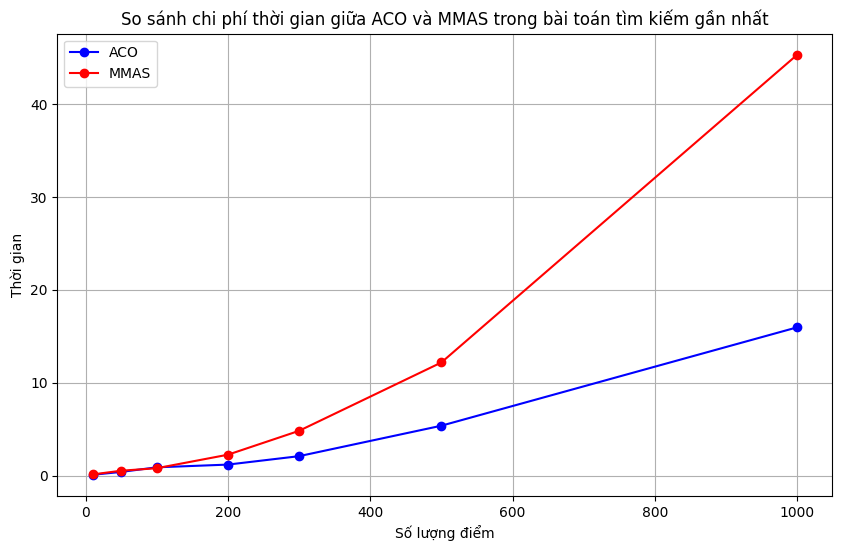

In [8]:
import math
import time
import matplotlib.pyplot as plt

def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# ACO
class ACO:
    def __init__(self, points, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_ants=10, num_iterations=100):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.pheromone = [[1 for _ in range(self.num_points)] for _ in range(self.num_points)]

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def update_pheromone(self, all_ants_paths, all_ants_lengths):
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.pheromone[i][j] *= (1 - self.evaporation_rate)
        for ant in range(self.num_ants):
            for i in range(len(all_ants_paths[ant]) - 1):
                from_point = all_ants_paths[ant][i]
                to_point = all_ants_paths[ant][i + 1]
                self.pheromone[from_point][to_point] += 1.0 / all_ants_lengths[ant]

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []
            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]
                for _ in range(n):
                    probabilities = []
                    total_prob = 0
                    for j in range(self.num_points):
                        if j not in visited:
                            prob = self.probability(current_index, j, heuristic)
                            probabilities.append((j, prob))
                            total_prob += prob
                    if total_prob > 0:
                        next_index = random.choices(
                            [point for point, _ in probabilities],
                            [prob / total_prob for _, prob in probabilities]
                        )[0]
                    else:
                        next_index = random.choice([i for i in range(self.num_points) if i not in visited])
                    visited.append(next_index)
                    current_index = next_index
                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)
            self.update_pheromone(all_ants_paths, all_ants_lengths)

        best_path = min(all_ants_paths, key=lambda path: sum([euclidean_distance(self.points[path[i]], self.points[path[i + 1]]) for i in range(len(path) - 1)]))
        return [self.points[i] for i in best_path]

# MMAS
class MMAS:
    def __init__(self, points, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_ants=10, num_iterations=100, tau_max=1.0, tau_min=0.1):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.tau_max = tau_max
        self.tau_min = tau_min
        self.pheromone = [[self.tau_max for _ in range(self.num_points)] for _ in range(self.num_points)]  # Khởi tạo pheromone

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def update_pheromone(self, best_path, best_length):
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.pheromone[i][j] *= (1 - self.evaporation_rate)
                self.pheromone[i][j] = max(self.tau_min, min(self.pheromone[i][j], self.tau_max))

        for i in range(len(best_path) - 1):
            from_point = best_path[i]
            to_point = best_path[i + 1]
            self.pheromone[from_point][to_point] += 1.0 / best_length
            self.pheromone[from_point][to_point] = min(self.pheromone[from_point][to_point], self.tau_max)

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)
        best_length = float('inf')
        best_path = []

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []

            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]

                for _ in range(n):
                    probabilities = []
                    total_prob = 0

                    for j in range(self.num_points):
                        if j not in visited:
                            prob = self.probability(current_index, j, heuristic)
                            probabilities.append((j, prob))
                            total_prob += prob

                    if total_prob > 0:
                        next_index = random.choices(
                            [point for point, _ in probabilities],
                            [prob / total_prob for _, prob in probabilities]
                        )[0]
                    else:
                        next_index = random.choice([i for i in range(self.num_points) if i not in visited])

                    visited.append(next_index)
                    current_index = next_index

                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)

                if total_length < best_length:
                    best_length = total_length
                    best_path = visited

            self.update_pheromone(best_path, best_length)

        return [self.points[i] for i in best_path[:n]]

# Tạo điểm ngẫu nhiên
def generate_random_points(num_points):
    return [(random.uniform(-90, 90), random.uniform(-180, 180)) for _ in range(num_points)]


num_points_list = [10, 50, 100, 200, 300, 500, 1000]
n = 5  # Số lượng điểm gần nhất cần tìm
reference_point_index = 0

aco_times = []
mmas_times = []

for num_points in num_points_list:
    points = generate_random_points(num_points)
    reference_point = points[reference_point_index]

    # Đo thời gian cho ACO
    aco = ACO(points, num_ants=20, num_iterations=50)
    start_time = time.time()
    nearest_points_aco = aco.run(reference_point, n)
    aco_time = time.time() - start_time
    aco_times.append(aco_time)

    # Đo thời gian cho MMAS
    mmas = MMAS(points, num_ants=20, num_iterations=50, tau_max=1.0, tau_min=0.1)
    start_time = time.time()
    nearest_points_mmas = mmas.run(reference_point, n)
    mmas_time = time.time() - start_time
    mmas_times.append(mmas_time)

# Vẽ biểu đồ so sánh thời gian giữa ACO và MMAS
plt.figure(figsize=(10, 6))
plt.plot(num_points_list, aco_times, label='ACO', marker='o', color='blue')
plt.plot(num_points_list, mmas_times, label='MMAS', marker='o', color='red')
plt.xlabel('Số lượng điểm')
plt.ylabel('Thời gian')
plt.title('So sánh chi phí thời gian giữa ACO và MMAS trong bài toán tìm kiếm gần nhất')
plt.legend()
plt.grid(True)
plt.show()

Áp dụng biến thể RAS trong tìm kiếm gần nhất

In [9]:
import random
import math

# Hàm tính khoảng cách Euclidean giữa 2 điểm
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Rank-based Ant System (RAS) Class
class RAS:
    def __init__(self, points, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_ants=10, num_iterations=100, elitism=5):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha  # Hệ số pheromone
        self.beta = beta  # Hệ số heuristic (khoảng cách)
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants  # Số lượng kiến
        self.num_iterations = num_iterations  # Số lần lặp
        self.elitism = elitism  # Số lượng kiến ưu tú
        self.pheromone = [[1 for _ in range(self.num_points)] for _ in range(self.num_points)]  # Khởi tạo pheromone

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def update_pheromone(self, ranked_paths, ranked_lengths):
        # Bay hơi pheromone
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.pheromone[i][j] *= (1 - self.evaporation_rate)

        # Cập nhật pheromone dựa trên xếp hạng các kiến
        for rank, (path, length) in enumerate(zip(ranked_paths, ranked_lengths)):
            weight = self.elitism - rank  # Trọng số cho kiến dựa trên xếp hạng
            for i in range(len(path) - 1):
                from_point = path[i]
                to_point = path[i + 1]
                self.pheromone[from_point][to_point] += weight / length

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []

            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]

                for _ in range(n):
                    probabilities = []
                    total_prob = 0

                    # Tính xác suất di chuyển tới các điểm chưa ghé qua
                    for j in range(self.num_points):
                        if j not in visited:
                            prob = self.probability(current_index, j, heuristic)
                            probabilities.append((j, prob))
                            total_prob += prob

                    # Chọn điểm tiếp theo dựa trên xác suất
                    if total_prob > 0:
                        next_index = random.choices(
                            [point for point, _ in probabilities],
                            [prob / total_prob for _, prob in probabilities]
                        )[0]
                    else:
                        next_index = random.choice([i for i in range(self.num_points) if i not in visited])

                    visited.append(next_index)
                    current_index = next_index

                # Tính tổng độ dài hành trình của kiến
                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)

            # Xếp hạng các kiến theo độ dài hành trình
            ranked_ants = sorted(zip(all_ants_paths, all_ants_lengths), key=lambda x: x[1])
            ranked_paths = [path for path, _ in ranked_ants[:self.elitism]]
            ranked_lengths = [length for _, length in ranked_ants[:self.elitism]]

            # Cập nhật pheromone dựa trên kiến được xếp hạng cao
            self.update_pheromone(ranked_paths, ranked_lengths)

        # Trả về các điểm gần nhất
        best_path = ranked_paths[0]
        return [self.points[i] for i in best_path[:n]]

# Tạo ngẫu nhiên các tọa độ điểm
def generate_random_points(num_points):
    return [(random.uniform(-90, 90), random.uniform(-180, 180)) for _ in range(num_points)]

# Tập dữ liệu điểm
points = generate_random_points(100)  # 100 điểm
reference_point = points[0]  # Điểm tham chiếu
n = 5  # Tìm 5 điểm gần nhất

# Khởi tạo RAS và tìm các điểm gần nhất
ras = RAS(points, num_ants=20, num_iterations=50, elitism=5)
nearest_points = ras.run(reference_point, n)

# In kết quả
print(f"Các điểm gần nhất với {reference_point} là:")
for i, point in enumerate(nearest_points, 1):
    print(f"{i}. {point}")


Các điểm gần nhất với (-13.913752394305419, 77.40377576438016) là:
1. (-13.913752394305419, 77.40377576438016)
2. (-7.36053929710927, 72.44810436406323)
3. (-3.462879279731581, 60.60167991594204)
4. (-15.804263545790462, 40.451760588944694)
5. (-24.565734892646375, 28.87308592649802)


Biểu đồ chi phí giữa ACO vs RAS

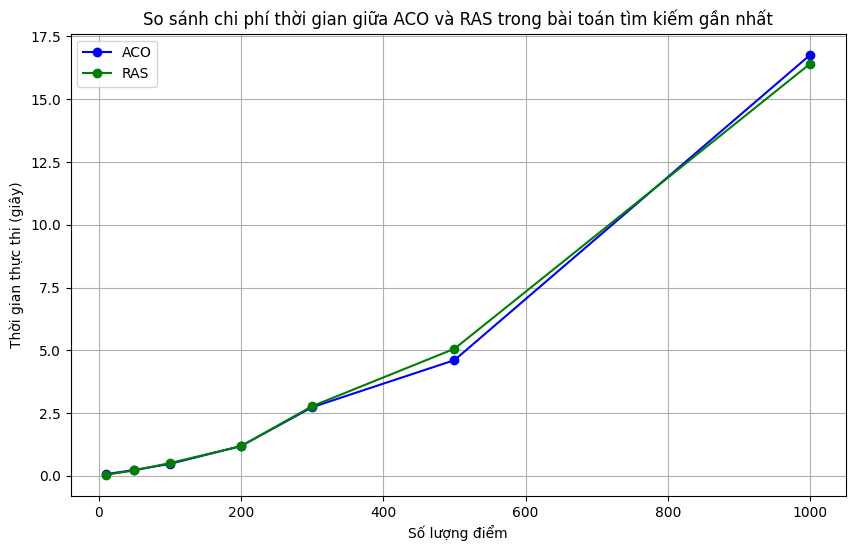

In [10]:
import time
import matplotlib.pyplot as plt

# Sử dụng lại hàm tính khoảng cách Euclidean và hàm generate_random_points từ trước
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Tạo điểm ngẫu nhiên
def generate_random_points(num_points):
    return [(random.uniform(-90, 90), random.uniform(-180, 180)) for _ in range(num_points)]

# Rank-based Ant System (RAS)
class RAS:
    def __init__(self, points, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_ants=10, num_iterations=100, elitism=5):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.elitism = elitism  # Số lượng kiến ưu tú
        self.pheromone = [[1 for _ in range(self.num_points)] for _ in range(self.num_points)]  # Khởi tạo pheromone

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def update_pheromone(self, ranked_paths, ranked_lengths):
        # Bay hơi pheromone
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.pheromone[i][j] *= (1 - self.evaporation_rate)

        # Cập nhật pheromone dựa trên xếp hạng các kiến
        for rank, (path, length) in enumerate(zip(ranked_paths, ranked_lengths)):
            weight = self.elitism - rank  # Trọng số cho kiến dựa trên xếp hạng
            for i in range(len(path) - 1):
                from_point = path[i]
                to_point = path[i + 1]
                self.pheromone[from_point][to_point] += weight / length

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []

            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]

                for _ in range(n):
                    probabilities = []
                    total_prob = 0

                    # Tính xác suất di chuyển tới các điểm chưa ghé qua
                    for j in range(self.num_points):
                        if j not in visited:
                            prob = self.probability(current_index, j, heuristic)
                            probabilities.append((j, prob))
                            total_prob += prob

                    # Chọn điểm tiếp theo dựa trên xác suất
                    if total_prob > 0:
                        next_index = random.choices(
                            [point for point, _ in probabilities],
                            [prob / total_prob for _, prob in probabilities]
                        )[0]
                    else:
                        next_index = random.choice([i for i in range(self.num_points) if i not in visited])

                    visited.append(next_index)
                    current_index = next_index

                # Tính tổng độ dài hành trình của kiến
                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)

            # Xếp hạng các kiến theo độ dài hành trình
            ranked_ants = sorted(zip(all_ants_paths, all_ants_lengths), key=lambda x: x[1])
            ranked_paths = [path for path, _ in ranked_ants[:self.elitism]]
            ranked_lengths = [length for _, length in ranked_ants[:self.elitism]]

            # Cập nhật pheromone dựa trên kiến được xếp hạng cao
            self.update_pheromone(ranked_paths, ranked_lengths)

        # Trả về các điểm gần nhất
        best_path = ranked_paths[0]
        return [self.points[i] for i in best_path[:n]]

# Số lượng điểm và số lượng gần nhất
num_points_list = [10, 50, 100, 200, 300, 500, 1000]  # Số lượng điểm khác nhau
n = 5  # Số lượng điểm gần nhất cần tìm
reference_point_index = 0

aco_times = []
ras_times = []

for num_points in num_points_list:
    points = generate_random_points(num_points)
    reference_point = points[reference_point_index]

    # Đo thời gian cho ACO
    aco = ACO(points, num_ants=20, num_iterations=50)
    start_time = time.time()
    nearest_points_aco = aco.run(reference_point, n)
    aco_time = time.time() - start_time
    aco_times.append(aco_time)

    # Đo thời gian cho RAS
    ras = RAS(points, num_ants=20, num_iterations=50, elitism=5)
    start_time = time.time()
    nearest_points_ras = ras.run(reference_point, n)
    ras_time = time.time() - start_time
    ras_times.append(ras_time)

# Vẽ biểu đồ so sánh thời gian giữa ACO và RAS
plt.figure(figsize=(10, 6))
plt.plot(num_points_list, aco_times, label='ACO', marker='o', color='blue')
plt.plot(num_points_list, ras_times, label='RAS', marker='o', color='green')
plt.xlabel('Số lượng điểm')
plt.ylabel('Thời gian thực thi (giây)')
plt.title('So sánh chi phí thời gian giữa ACO và RAS trong bài toán tìm kiếm gần nhất')
plt.legend()
plt.grid(True)
plt.show()


Áp dụng EAS vào trong tìm kiếm gần nhất

In [11]:
import random
import math

# Hàm tính khoảng cách Euclidean giữa 2 điểm
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Elitist Ant System (EAS) Class
class EAS:
    def __init__(self, points, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_ants=10, num_iterations=100, elite_weight=5):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha  # Hệ số pheromone
        self.beta = beta  # Hệ số heuristic (khoảng cách)
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants  # Số lượng kiến
        self.num_iterations = num_iterations  # Số lần lặp
        self.elite_weight = elite_weight  # Trọng số kiến ưu tú
        self.pheromone = [[1 for _ in range(self.num_points)] for _ in range(self.num_points)]  # Khởi tạo pheromone

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def update_pheromone(self, all_ants_paths, all_ants_lengths, best_path, best_length):
        # Bay hơi pheromone
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.pheromone[i][j] *= (1 - self.evaporation_rate)

        # Cập nhật pheromone từ tất cả các kiến
        for path, length in zip(all_ants_paths, all_ants_lengths):
            for i in range(len(path) - 1):
                from_point = path[i]
                to_point = path[i + 1]
                self.pheromone[from_point][to_point] += 1.0 / length

        # Cập nhật pheromone từ kiến ưu tú (elite ant)
        for i in range(len(best_path) - 1):
            from_point = best_path[i]
            to_point = best_path[i + 1]
            self.pheromone[from_point][to_point] += self.elite_weight / best_length

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)
        best_length = float('inf')
        best_path = []

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []

            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]

                for _ in range(n):
                    probabilities = []
                    total_prob = 0

                    # Tính xác suất di chuyển tới các điểm chưa ghé qua
                    for j in range(self.num_points):
                        if j not in visited:
                            prob = self.probability(current_index, j, heuristic)
                            probabilities.append((j, prob))
                            total_prob += prob

                    # Chọn điểm tiếp theo dựa trên xác suất
                    if total_prob > 0:
                        next_index = random.choices(
                            [point for point, _ in probabilities],
                            [prob / total_prob for _, prob in probabilities]
                        )[0]
                    else:
                        next_index = random.choice([i for i in range(self.num_points) if i not in visited])

                    visited.append(next_index)
                    current_index = next_index

                # Tính tổng độ dài hành trình của kiến
                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)

                # Cập nhật hành trình tốt nhất
                if total_length < best_length:
                    best_length = total_length
                    best_path = visited

            # Cập nhật pheromone với kiến ưu tú
            self.update_pheromone(all_ants_paths, all_ants_lengths, best_path, best_length)

        # Trả về các điểm gần nhất
        return [self.points[i] for i in best_path[:n]]

# Tạo ngẫu nhiên các tọa độ điểm
def generate_random_points(num_points):
    return [(random.uniform(-90, 90), random.uniform(-180, 180)) for _ in range(num_points)]

# Tập dữ liệu điểm
points = generate_random_points(100)  # 100 điểm
reference_point = points[0]  # Điểm tham chiếu
n = 5  # Tìm 5 điểm gần nhất

# Khởi tạo EAS và tìm các điểm gần nhất
eas = EAS(points, num_ants=20, num_iterations=50, elite_weight=5)
nearest_points = eas.run(reference_point, n)

# In kết quả
print(f"Các điểm gần nhất với {reference_point} là:")
for i, point in enumerate(nearest_points, 1):
    print(f"{i}. {point}")


Các điểm gần nhất với (-67.65871025001786, -153.397534396938) là:
1. (-67.65871025001786, -153.397534396938)
2. (-7.667709870109704, -166.58868082004253)
3. (1.8440148121326274, -167.4358630636059)
4. (17.406861716851353, -169.64575790625142)
5. (22.031908718840057, -154.25327290216578)


Biểu đồ chi phí giứa ACO vs EAS

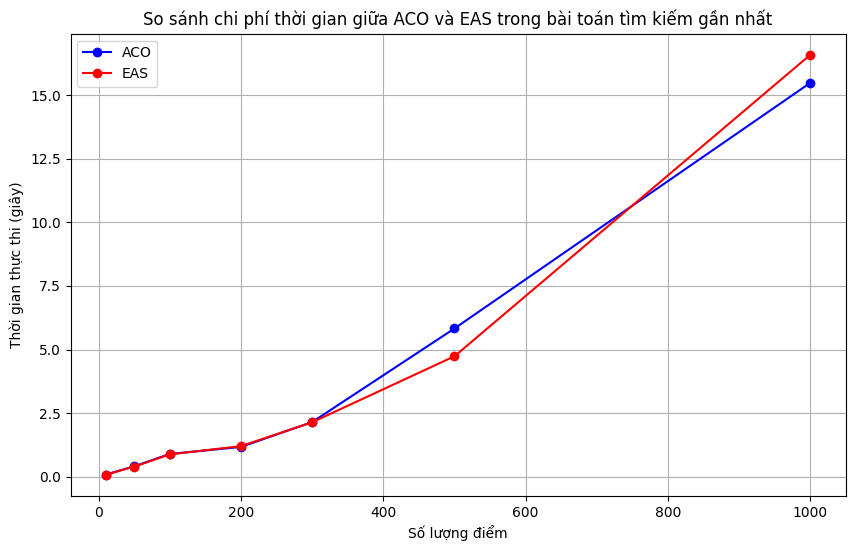

In [12]:
import time
import matplotlib.pyplot as plt

# Elitist Ant System (EAS)
class EAS:
    def __init__(self, points, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_ants=10, num_iterations=100, elite_weight=5):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.elite_weight = elite_weight  # Trọng số cho kiến ưu tú
        self.pheromone = [[1 for _ in range(self.num_points)] for _ in range(self.num_points)]  # Khởi tạo pheromone

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def update_pheromone(self, all_ants_paths, all_ants_lengths, best_path, best_length):
        # Bay hơi pheromone
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.pheromone[i][j] *= (1 - self.evaporation_rate)

        # Cập nhật pheromone từ tất cả các kiến
        for path, length in zip(all_ants_paths, all_ants_lengths):
            for i in range(len(path) - 1):
                from_point = path[i]
                to_point = path[i + 1]
                self.pheromone[from_point][to_point] += 1.0 / length

        # Cập nhật pheromone từ kiến ưu tú
        for i in range(len(best_path) - 1):
            from_point = best_path[i]
            to_point = best_path[i + 1]
            self.pheromone[from_point][to_point] += self.elite_weight / best_length

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)
        best_length = float('inf')
        best_path = []

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []

            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]

                for _ in range(n):
                    probabilities = []
                    total_prob = 0

                    # Tính xác suất di chuyển tới các điểm chưa ghé qua
                    for j in range(self.num_points):
                        if j not in visited:
                            prob = self.probability(current_index, j, heuristic)
                            probabilities.append((j, prob))
                            total_prob += prob

                    # Chọn điểm tiếp theo dựa trên xác suất
                    if total_prob > 0:
                        next_index = random.choices(
                            [point for point, _ in probabilities],
                            [prob / total_prob for _, prob in probabilities]
                        )[0]
                    else:
                        next_index = random.choice([i for i in range(self.num_points) if i not in visited])

                    visited.append(next_index)
                    current_index = next_index

                # Tính tổng độ dài hành trình của kiến
                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)

                # Cập nhật hành trình tốt nhất
                if total_length < best_length:
                    best_length = total_length
                    best_path = visited

            # Cập nhật pheromone với kiến ưu tú
            self.update_pheromone(all_ants_paths, all_ants_lengths, best_path, best_length)

        # Trả về các điểm gần nhất
        return [self.points[i] for i in best_path[:n]]

# Số lượng điểm và số lượng gần nhất
num_points_list = [10, 50, 100, 200, 300, 500, 1000]  # Số lượng điểm khác nhau
n = 5  # Số lượng điểm gần nhất cần tìm
reference_point_index = 0

aco_times = []
eas_times = []

for num_points in num_points_list:
    points = generate_random_points(num_points)
    reference_point = points[reference_point_index]

    # Đo thời gian cho ACO
    aco = ACO(points, num_ants=20, num_iterations=50)
    start_time = time.time()
    nearest_points_aco = aco.run(reference_point, n)
    aco_time = time.time() - start_time
    aco_times.append(aco_time)

    # Đo thời gian cho EAS
    eas = EAS(points, num_ants=20, num_iterations=50, elite_weight=5)
    start_time = time.time()
    nearest_points_eas = eas.run(reference_point, n)
    eas_time = time.time() - start_time
    eas_times.append(eas_time)

# Vẽ biểu đồ so sánh thời gian giữa ACO và EAS
plt.figure(figsize=(10, 6))
plt.plot(num_points_list, aco_times, label='ACO', marker='o', color='blue')
plt.plot(num_points_list, eas_times, label='EAS', marker='o', color='red')
plt.xlabel('Số lượng điểm')
plt.ylabel('Thời gian thực thi (giây)')
plt.title('So sánh chi phí thời gian giữa ACO và EAS trong bài toán tìm kiếm gần nhất')
plt.legend()
plt.grid(True)
plt.show()


Cách triển khai kết hợp GA và ACO trong thuật toán tìm kiếm

In [13]:
import random
import math

# Hàm tính khoảng cách Euclidean giữa 2 điểm
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Genetic Algorithm (GA) để tạo tập hợp lời giải ban đầu
class GA:
    def __init__(self, points, population_size=20, mutation_rate=0.1, generations=50):
        self.points = points
        self.num_points = len(points)
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations

    # Tạo cá thể ngẫu nhiên (một hành trình ngẫu nhiên qua các điểm)
    def create_individual(self):
        return random.sample(self.points, len(self.points))

    # Tạo quần thể ban đầu
    def create_population(self):
        return [self.create_individual() for _ in range(self.population_size)]

    # Hàm fitness đánh giá cá thể (tổng khoảng cách của hành trình)
    def fitness(self, individual):
        return sum([euclidean_distance(individual[i], individual[i + 1]) for i in range(len(individual) - 1)])

    # Chọn lựa cá thể (Chọn cá thể tốt nhất trong quần thể)
    def selection(self, population):
        return sorted(population, key=self.fitness)[:self.population_size // 2]

    # Lai ghép (Crossover)
    def crossover(self, parent1, parent2):
        split = random.randint(0, self.num_points - 1)
        child = parent1[:split] + [point for point in parent2 if point not in parent1[:split]]
        return child

    # Đột biến (Mutation)
    def mutate(self, individual):
        if random.random() < self.mutation_rate:
            idx1, idx2 = random.sample(range(len(individual)), 2)
            individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

    # Hàm chạy GA
    def run(self):
        population = self.create_population()
        for _ in range(self.generations):
            selected_population = self.selection(population)
            next_generation = []
            while len(next_generation) < self.population_size:
                parent1, parent2 = random.sample(selected_population, 2)
                child = self.crossover(parent1, parent2)
                self.mutate(child)
                next_generation.append(child)
            population = next_generation
        return self.selection(population)

# Ant Colony Optimization (ACO)
class ACO:
    def __init__(self, points, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_ants=10, num_iterations=50):
        self.points = points
        self.num_points = len(points)
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.pheromone = [[1 for _ in range(self.num_points)] for _ in range(self.num_points)]  # Khởi tạo pheromone

    def probability(self, i, j, heuristic):
        return (self.pheromone[i][j] ** self.alpha) * (heuristic[i][j] ** self.beta)

    def update_pheromone(self, all_ants_paths, all_ants_lengths):
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.pheromone[i][j] *= (1 - self.evaporation_rate)
        for path, length in zip(all_ants_paths, all_ants_lengths):
            for i in range(len(path) - 1):
                from_point = path[i]
                to_point = path[i + 1]
                self.pheromone[from_point][to_point] += 1.0 / length

    def run(self, reference_point, n):
        heuristic = [[1 / euclidean_distance(p1, p2) if euclidean_distance(p1, p2) != 0 else 0 for p2 in self.points] for p1 in self.points]
        reference_index = self.points.index(reference_point)
        best_path = []
        best_length = float('inf')

        for _ in range(self.num_iterations):
            all_ants_paths = []
            all_ants_lengths = []

            for _ in range(self.num_ants):
                current_index = reference_index
                visited = [current_index]

                for _ in range(n):
                    probabilities = []
                    total_prob = 0
                    for j in range(self.num_points):
                        if j not in visited:
                            prob = self.probability(current_index, j, heuristic)
                            probabilities.append((j, prob))
                            total_prob += prob

                    if total_prob > 0:
                        next_index = random.choices(
                            [point for point, _ in probabilities],
                            [prob / total_prob for _, prob in probabilities]
                        )[0]
                    else:
                        next_index = random.choice([i for i in range(self.num_points) if i not in visited])

                    visited.append(next_index)
                    current_index = next_index

                total_length = sum([euclidean_distance(self.points[visited[i]], self.points[visited[i + 1]]) for i in range(len(visited) - 1)])
                all_ants_paths.append(visited)
                all_ants_lengths.append(total_length)

                if total_length < best_length:
                    best_length = total_length
                    best_path = visited

            self.update_pheromone(all_ants_paths, all_ants_lengths)

        return [self.points[i] for i in best_path[:n]]

# Tạo ngẫu nhiên các tọa độ điểm
def generate_random_points(num_points):
    return [(random.uniform(-90, 90), random.uniform(-180, 180)) for _ in range(num_points)]

# Số lượng điểm cần tìm
points = generate_random_points(100)  # 100 điểm
reference_point = points[0]  # Điểm tham chiếu
n = 5  # Tìm 5 điểm gần nhất

# Chạy GA để tạo tập lời giải ban đầu
ga = GA(points, population_size=20, generations=30)
population = ga.run()

# Áp dụng ACO để tối ưu tập lời giải từ GA
aco = ACO(points, num_ants=20, num_iterations=50)
nearest_points = aco.run(reference_point, n)

# In kết quả
print(f"Các điểm gần nhất với {reference_point} là:")
for i, point in enumerate(nearest_points, 1):
    print(f"{i}. {point}")

Các điểm gần nhất với (-42.60830814193972, 40.426578595941436) là:
1. (-42.60830814193972, 40.426578595941436)
2. (-31.23474877709713, 41.77109407333694)
3. (-17.507326267722718, 42.344200937776776)
4. (-19.300150350168835, 45.1249778345653)
5. (-9.908753133664419, 73.48768104040005)


Biểu đồ chi phí giứa ACO + GA vs ACO

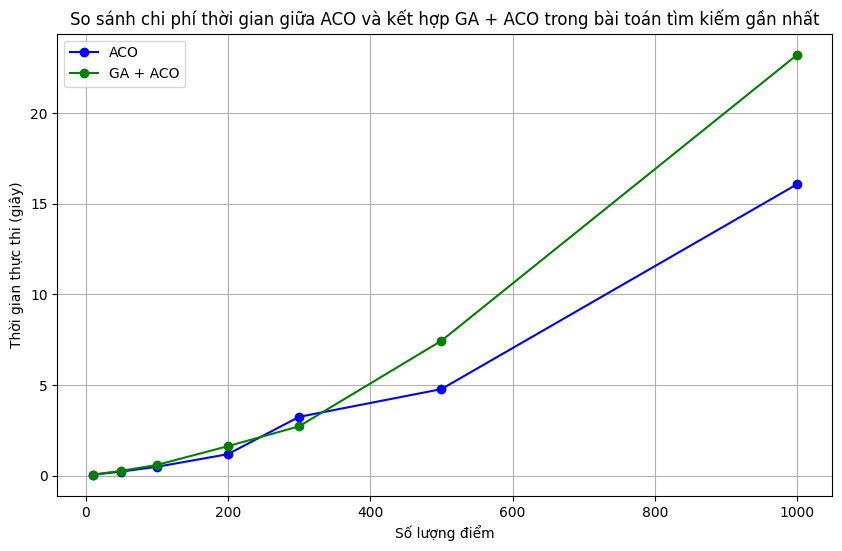

In [14]:
import time
import matplotlib.pyplot as plt

# Số lượng điểm và số lượng gần nhất
num_points_list = [10, 50, 100, 200, 300, 500, 1000]  # Số lượng điểm khác nhau
n = 5  # Số lượng điểm gần nhất cần tìm
reference_point_index = 0

aco_times = []
ga_aco_times = []

for num_points in num_points_list:
    points = generate_random_points(num_points)
    reference_point = points[reference_point_index]

    # Đo thời gian cho ACO gốc
    aco = ACO(points, num_ants=20, num_iterations=50)
    start_time = time.time()
    nearest_points_aco = aco.run(reference_point, n)
    aco_time = time.time() - start_time
    aco_times.append(aco_time)

    # Đo thời gian cho sự kết hợp GA và ACO
    ga = GA(points, population_size=20, generations=30)
    start_time = time.time()
    population = ga.run()
    aco = ACO(points, num_ants=20, num_iterations=50)
    nearest_points_ga_aco = aco.run(reference_point, n)
    ga_aco_time = time.time() - start_time
    ga_aco_times.append(ga_aco_time)

# Vẽ biểu đồ so sánh thời gian giữa ACO và sự kết hợp GA + ACO
plt.figure(figsize=(10, 6))
plt.plot(num_points_list, aco_times, label='ACO', marker='o', color='blue')
plt.plot(num_points_list, ga_aco_times, label='GA + ACO', marker='o', color='green')
plt.xlabel('Số lượng điểm')
plt.ylabel('Thời gian thực thi (giây)')
plt.title('So sánh chi phí thời gian giữa ACO và kết hợp GA + ACO trong bài toán tìm kiếm gần nhất')
plt.legend()
plt.grid(True)
plt.show()

Đánh giá khi tăng số lượng điểm hơn ở cách GA+ACO vs ACO

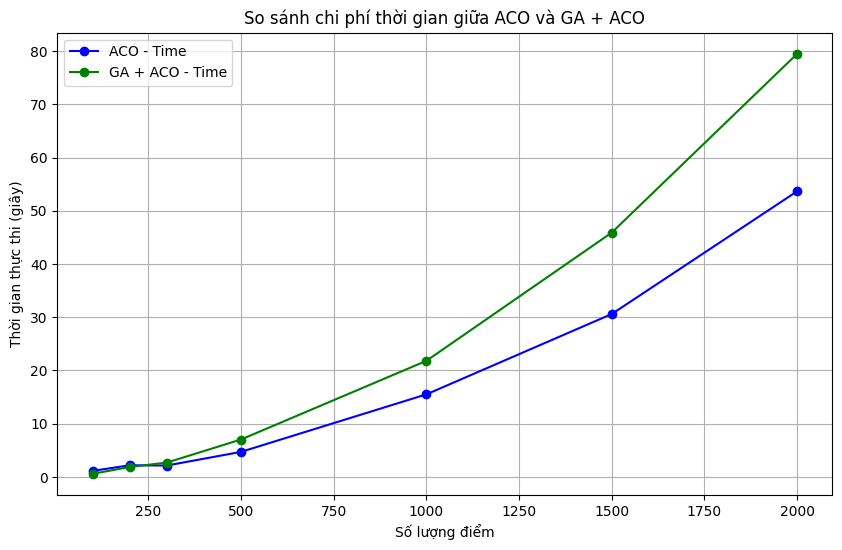

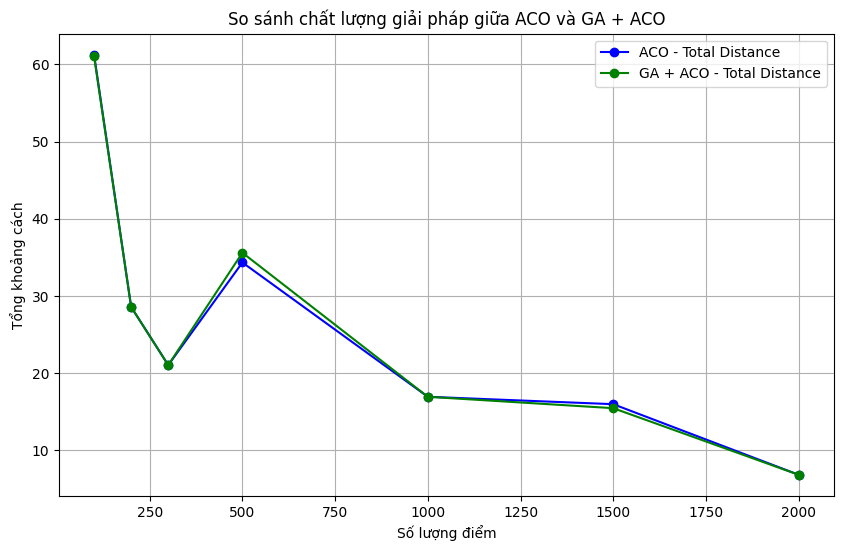

In [15]:
import random
import math
import time
import matplotlib.pyplot as plt

# Hàm tính khoảng cách Euclidean giữa 2 điểm
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# GA và ACO đã được định nghĩa trước đó

# Hàm đánh giá tổng khoảng cách của hành trình
def evaluate_path(path):
    return sum([euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1)])

# Số lượng điểm và số lượng gần nhất
num_points_list = [100, 200, 300, 500, 1000, 1500, 2000]  # Tăng số lượng điểm
n = 5  # Số lượng điểm gần nhất cần tìm
reference_point_index = 0

aco_times = []
ga_aco_times = []
aco_solutions = []
ga_aco_solutions = []

for num_points in num_points_list:
    points = generate_random_points(num_points)
    reference_point = points[reference_point_index]

    # Đo thời gian và chất lượng giải pháp cho ACO gốc
    aco = ACO(points, num_ants=20, num_iterations=50)
    start_time = time.time()
    nearest_points_aco = aco.run(reference_point, n)
    aco_time = time.time() - start_time
    aco_times.append(aco_time)

    # Tính tổng khoảng cách cho hành trình tìm được bởi ACO
    aco_solution = evaluate_path(nearest_points_aco)
    aco_solutions.append(aco_solution)

    # Đo thời gian và chất lượng giải pháp cho sự kết hợp GA và ACO
    ga = GA(points, population_size=20, generations=30)
    start_time = time.time()
    population = ga.run()
    aco = ACO(points, num_ants=20, num_iterations=50)
    nearest_points_ga_aco = aco.run(reference_point, n)
    ga_aco_time = time.time() - start_time
    ga_aco_times.append(ga_aco_time)

    # Tính tổng khoảng cách cho hành trình tìm được bởi GA + ACO
    ga_aco_solution = evaluate_path(nearest_points_ga_aco)
    ga_aco_solutions.append(ga_aco_solution)

# Vẽ biểu đồ so sánh thời gian giữa ACO và GA + ACO
plt.figure(figsize=(10, 6))
plt.plot(num_points_list, aco_times, label='ACO - Time', marker='o', color='blue')
plt.plot(num_points_list, ga_aco_times, label='GA + ACO - Time', marker='o', color='green')
plt.xlabel('Số lượng điểm')
plt.ylabel('Thời gian thực thi (giây)')
plt.title('So sánh chi phí thời gian giữa ACO và GA + ACO')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ so sánh chất lượng giải pháp (tổng khoảng cách)
plt.figure(figsize=(10, 6))
plt.plot(num_points_list, aco_solutions, label='ACO - Total Distance', marker='o', color='blue')
plt.plot(num_points_list, ga_aco_solutions, label='GA + ACO - Total Distance', marker='o', color='green')
plt.xlabel('Số lượng điểm')
plt.ylabel('Tổng khoảng cách')
plt.title('So sánh chất lượng giải pháp giữa ACO và GA + ACO')
plt.legend()
plt.grid(True)
plt.show()
